Looking at how birds space themselves out in the flock. Real starling flocks show an exclusion zone, birds avoid getting too close to each other due to physical constraints and collision avoidance. We test whether changing noise/alignment shifts the NN distribution.

The key observation from Ballerini et al. 2008 is that the nearest neighbor distance distribution has a sharp cutoff at small distances, rather than going smoothly to zero. This tells us birds maintain minimum spacing. We test if varying the repulsion strength changes this qualitatively or just shifts the cutoff distance.

In [6]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(Path.cwd().parent))

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from src.metrics import nearest_neighbor_distance
from src.flocking_sim import run_simulation
from scipy.stats import gaussian_kde


# Configuration
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.dpi'] = 100

We need a function to compute nearest-neighbor distances under periodic boundaries. The minimum-image convention ensures we find the true nearest neighbor even if it's across the box edge.

In [7]:
def collect_nn_data(N=200, align=1.5, noise=0.1, n_seeds=5, burn_in_frac=0.6):
    """
    Run the simulation and collect nearest-neighbor (NN) distance
    data from the steady-state regime.

    Parameters
    ----------
    N : int
        Number of particles.
    align : float
        Alignment strength.
    noise : float
        Noise level.
    n_seeds : int
        Number of random seeds.
    burn_in_frac : float
        Fraction of initial frames discarded as burn-in.

    Returns
    -------
    all_nn_distances : np.ndarray
        Nearest-neighbor distances from all seeds and
        all frames in the steady-state regime.
    """

    print(f"Running: N={N}, align={align}, noise={noise}")
    print(f"  Seeds: {n_seeds}, burn-in: {burn_in_frac*100:.0f}%")

    all_nn_distances = []

    for seed in range(n_seeds):
        # Run 2D Vicsek simulation (no repulsion)
        history = run_simulation(
            N=N,
            steps=500,
            align=align,
            noise=noise,
            R=0.15,
            speed=0.03,
            box_size=1.0,
            seed=seed,
            save_every=10
        )

        # Use the final portion of the trajectory as steady state
        burn_in_idx = int(len(history) * burn_in_frac)
        steady_state = history[burn_in_idx:]

        # Compute NN distances for each frame
        for pos in steady_state:
            nn_dist = nearest_neighbor_distance(pos, box_size=1.0)
            all_nn_distances.append(nn_dist)
            
        print(f"  Seed {seed}: {len(steady_state)} frames")

    all_nn_distances = np.array(all_nn_distances)

    print(f"✓ Collected {len(all_nn_distances)} NN distance data points")
    print(f"  Range: [{all_nn_distances.min():.4f}, {all_nn_distances.max():.4f}]")
    print(f"  Mean: {all_nn_distances.mean():.4f} ± {all_nn_distances.std():.4f}")

    return all_nn_distances


print("✓ Function defined: collect_nn_data")

✓ Function defined: collect_nn_data


## 2. Baseline Analysis

We begin by examining the nearest-neighbour (NN) distance distribution in the 2D Vicsek model as a simple measure of local spacing between agents. 
Our aim is to see whether extremely small separations occur frequently, or whether particles tend to maintain a characteristic distance from their neighbours.

Even though the model does not include an explicit repulsion term, very small NN distances are strongly suppressed. 
This suggests that local spacing can emerge from alignment and noise alone.

We treat this analysis as a local sanity check on the microscopic behaviour of the model, rather than as a direct comparison to 3D geometric measurements in real bird flocks.

In [8]:
import inspect
print("collect_nn_data defined in:", inspect.getsourcefile(collect_nn_data))
print("signature:", inspect.signature(collect_nn_data))

# Run baseline simulation
nn_baseline = collect_nn_data(
    N=200,
    align=1.5,
    noise=0.10,
    n_seeds=5
)

collect_nn_data defined in: /var/folders/j2/cqr08d2s397gnw45f7v3lt4w0000gn/T/ipykernel_26130/821939518.py
signature: (N=200, align=1.5, noise=0.1, n_seeds=5, burn_in_frac=0.6)
Running: N=200, align=1.5, noise=0.1
  Seeds: 5, burn-in: 60%
  Seed 0: 20 frames
  Seed 1: 20 frames
  Seed 2: 20 frames
  Seed 3: 20 frames
  Seed 4: 20 frames
✓ Collected 100 NN distance data points
  Range: [0.0324, 0.0385]
  Mean: 0.0354 ± 0.0013


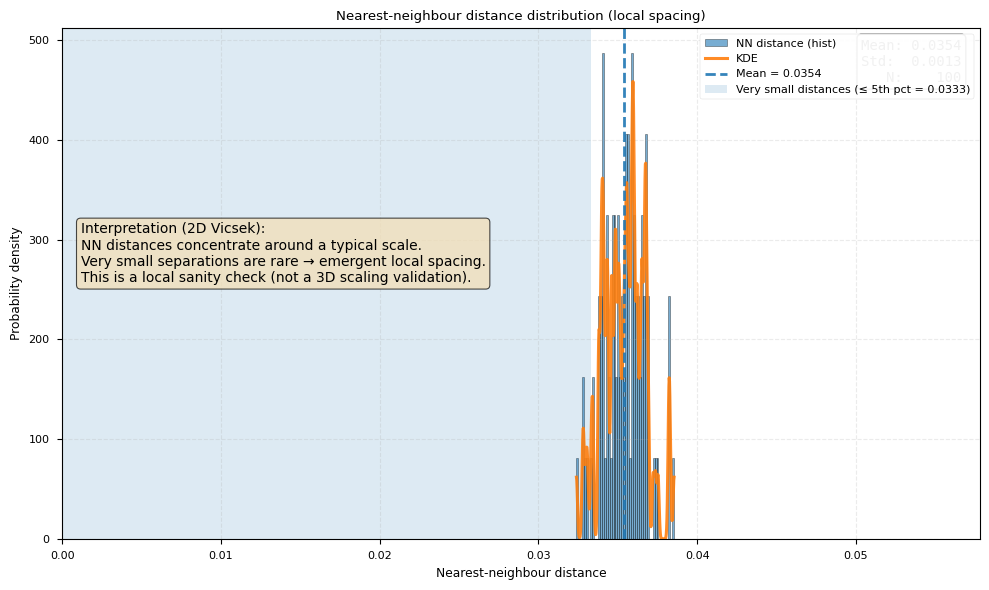

✓ Figure: NN distance distribution (local spacing sanity check)


In [ ]:
# NN distance distribution (2D Vicsek)

data = np.asarray(nn_baseline)
data = data[np.isfinite(data)]  
if len(data) == 0:
    raise ValueError("nn_baseline is empty or contains no finite values.")

fig, ax = plt.subplots(figsize=(10, 6))

# Histogram + KDE
bins = 50
ax.hist(
    data,
    bins=bins,
    density=True,
    alpha=0.6,
    edgecolor="black",
    linewidth=0.4,
    label="NN distance (hist)"
)

kde = gaussian_kde(data, bw_method=0.05) # tune if too smooth
x = np.linspace(data.min(), data.max(), 300)
ax.plot(x, kde(x), linewidth=2.2, alpha=0.9, label="KDE")

# Summary markers 
mean_val = data.mean()
std_val  = data.std()
q05 = np.quantile(data, 0.05)

ax.axvline(mean_val, linestyle="--", linewidth=2.0, alpha=0.9,
           label=f"Mean = {mean_val:.4f}")

ax.axvspan(0, q05, alpha=0.15,
           label=f"Very small distances (≤ 5th pct = {q05:.4f})")

# Compact annotation
stats_text = (
    f"Mean: {mean_val:.4f}\n"
    f"Std:  {std_val:.4f}\n"
    f"N:    {len(data)}"
)
ax.text(
    0.98, 0.98, stats_text,
    transform=ax.transAxes,
    ha="right", va="top",
    fontsize=10, family="monospace",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9, linewidth=1.0)
)

interpretation = (
    "Interpretation (2D Vicsek):\n"
    "NN distances concentrate around a typical scale.\n"
    "Very small separations are rare → emergent local spacing.\n"
    "This is a local sanity check (not a 3D scaling validation)."
)
ax.text(
    0.02, 0.62, interpretation,
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=10,
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.7, linewidth=0.8)
)

# Axes 
ax.set_xlabel("Nearest-neighbour distance")
ax.set_ylabel("Probability density")
ax.set_title("Nearest-neighbour distance distribution (local spacing)")
ax.legend(loc="upper right", framealpha=0.95)
ax.grid(True, alpha=0.25, linestyle="--")

# Keep x-range tight (robust to rare outliers)
x_max = max(data.max() * 1.5, mean_val + 4 * std_val)
ax.set_xlim(0, x_max)

plt.tight_layout()
plt.show()

print("✓ Figure: NN distance distribution (local spacing sanity check)")

## 3. Robustness Check
To check robustness, we vary the noise level in the 2D Vicsek model and compare the resulting NN distance distributions.
As noise increases, the typical NN distance shifts slightly, but the overall shape of the distribution remains similar.

In particular, very small separations continue to be rare across the tested noise range, suggesting that the observed local spacing does not rely on a fine-tuned choice of parameters.

In [11]:
# Test different repulsion radii
noise_levels = [0.05, 0.10, 0.20]
nn_distributions = {}

for eta in noise_levels:
    print(f"\n--- Noise level = {eta} ---")
    nn_dist = collect_nn_data(
        N=200,
        align=1.5,
        noise=eta,
        n_seeds=3   # fewer seeds for robustness check
    )
    nn_distributions[eta] = nn_dist

print("\n✓ Robustness check (noise) complete")


--- Noise level = 0.05 ---
Running: N=200, align=1.5, noise=0.05
  Seeds: 3, burn-in: 60%
  Seed 0: 20 frames
  Seed 1: 20 frames
  Seed 2: 20 frames
✓ Collected 60 NN distance data points
  Range: [0.0320, 0.0387]
  Mean: 0.0354 ± 0.0014

--- Noise level = 0.1 ---
Running: N=200, align=1.5, noise=0.1
  Seeds: 3, burn-in: 60%
  Seed 0: 20 frames
  Seed 1: 20 frames
  Seed 2: 20 frames
✓ Collected 60 NN distance data points
  Range: [0.0324, 0.0385]
  Mean: 0.0353 ± 0.0014

--- Noise level = 0.2 ---
Running: N=200, align=1.5, noise=0.2
  Seeds: 3, burn-in: 60%
  Seed 0: 20 frames
  Seed 1: 20 frames
  Seed 2: 20 frames
✓ Collected 60 NN distance data points
  Range: [0.0319, 0.0392]
  Mean: 0.0351 ± 0.0014

✓ Robustness check (noise) complete


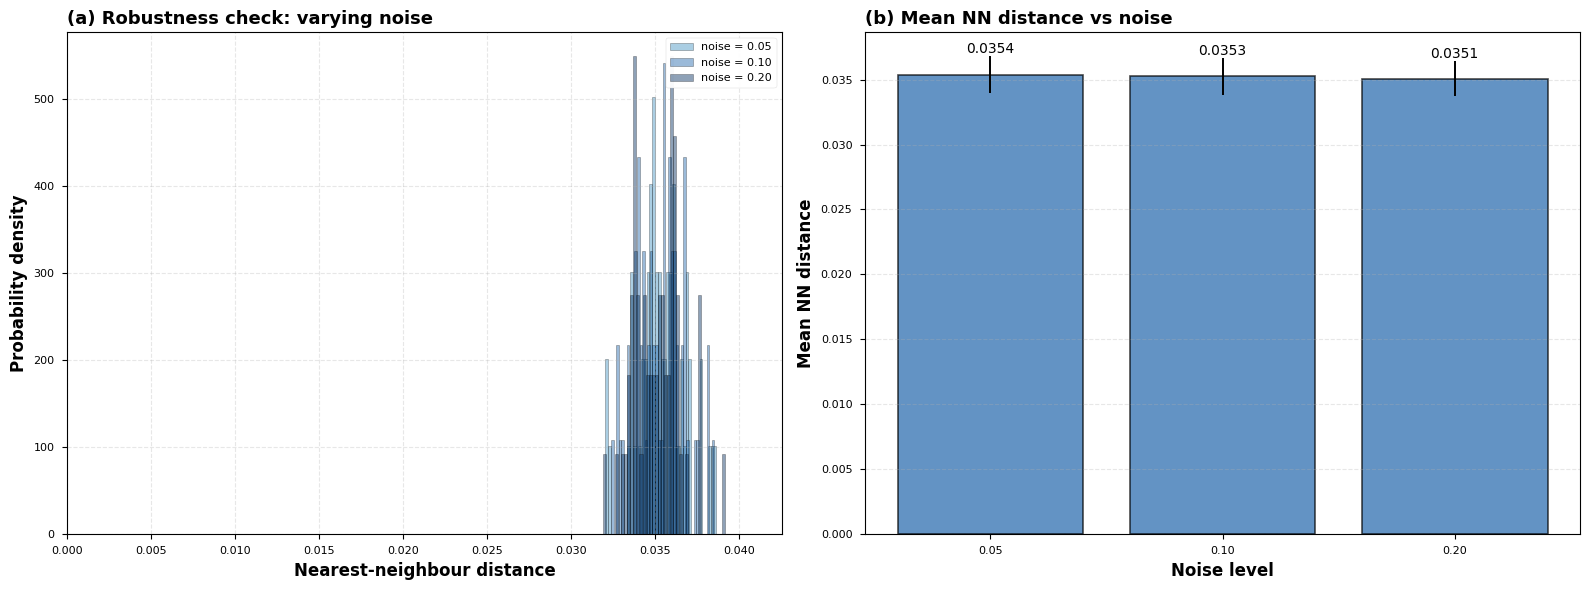


✓ Figure 2: Robustness check (varying noise)


In [ ]:
# Robustness comparison (varying noise) 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sort keys to keep a fixed order
noise_levels = sorted(nn_distributions.keys())

# Left panel: NN distance distributions at different noise levels
colors = ['#4393c3', '#2166ac', '#053061', '#67001f', '#b2182b']  # enough colors
for i, eta in enumerate(noise_levels):
    nn_dist = nn_distributions[eta]

    axes[0].hist(
        nn_dist,
        bins=40,
        density=True,
        alpha=0.45,
        color=colors[i % len(colors)],
        edgecolor='black',
        linewidth=0.4,
        label=f'noise = {eta:.2f}'
    )

axes[0].set_xlabel('Nearest-neighbour distance', fontsize=12, weight='bold')
axes[0].set_ylabel('Probability density', fontsize=12, weight='bold')
axes[0].set_title('(a) Robustness check: varying noise', fontsize=13, weight='bold', loc='left')
axes[0].legend(loc='upper right', framealpha=0.95)
axes[0].grid(True, alpha=0.3, linestyle='--')

# Set a tight x-range based on the data
all_vals = np.concatenate([nn_distributions[k] for k in noise_levels])
x_hi = np.quantile(all_vals, 0.995)
axes[0].set_xlim(0, x_hi * 1.1)

# Right panel: mean NN distance with standard deviation
means = [nn_distributions[eta].mean() for eta in noise_levels]
stds  = [nn_distributions[eta].std()  for eta in noise_levels]

x_pos = np.arange(len(noise_levels))
axes[1].bar(
    x_pos, means, yerr=stds,
    capsize=5,
    alpha=0.7,
    color='#2166ac',
    edgecolor='black',
    linewidth=1.2
)

for i, (m, s) in enumerate(zip(means, stds)):
    axes[1].text(i, m + s, f'{m:.4f}', ha='center', va='bottom', fontsize=10)

axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'{eta:.2f}' for eta in noise_levels])
axes[1].set_xlabel('Noise level', fontsize=12, weight='bold')
axes[1].set_ylabel('Mean NN distance', fontsize=12, weight='bold')
axes[1].set_title('(b) Mean NN distance vs noise', fontsize=13, weight='bold', loc='left')
axes[1].grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.show()

print("\n✓ Figure 2: Robustness check (varying noise)")

## 4. Summary

We analysed nearest-neighbour (NN) distances in the 2D Vicsek model to understand the local spacing between agents.  
In the baseline case, the NN distances are concentrated around a typical value, and very small separations occur only rarely. This suggests that the model produces a well-defined local spacing at the microscopic level.

We then repeated the same analysis for different noise levels. While the mean NN distance changes slightly as noise increases, the overall shape of the distribution remains similar. The transition is smooth rather than abrupt, and no qualitative change in behaviour is observed.

Overall, these results indicate that the local spacing seen in the 2D model is not sensitive to a single parameter choice, but persists across a reasonable range of noise values. This NN analysis is used as a local sanity check of the model behaviour and is not intended as a direct comparison with the 3D geometric scaling results for real bird flocks.

In [15]:
import os
os.makedirs('../results', exist_ok=True)

# Save baseline NN distance data
np.save('../results/nn_distances_baseline.npy', nn_baseline)

# Save robustness check data (varying noise)
for eta, nn_dist in nn_distributions.items():
    np.save(f'../results/nn_distances_noise_{eta:.2f}.npy', nn_dist)

print("✓ Data saved to ../results/")

✓ Data saved to ../results/
